In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
%matplotlib inline

Assumptions in our code:

1. We assume the following following column names in the bond data: "StartTime", "Maturity", "Coupon", "Price".
2. We assume the liabilities file the columns: "Year" and "Liability". 
3. The maturity date of the longest tenured bond is greater than or equal to the furthest liability year.

Read in the data from the two csv files that should be located in the same folder as this notebook.

In [2]:
data = pd.read_csv('bonds.csv')
liability_df = pd.read_csv('liabilities.csv')

We first want to make several adjustments to our bond data frame so that our data is easier to analyze:
* Add an indicator column called 'forward' which lets us know if the bond is a forward or not
* Create new columns on our data which correspond to the yearly expected cash flows of each bond. The price paid for the bond is represented as a negative cash flow.

In [3]:

def create_cf_vector(row, longest_maturity: int):
    """This function is used to create a bonds projected cash flows based on its coupon, start time, end time, and price.
    The input is a row of our bond dataframe and the output is a cashh flow vector that corresponds to that bonds project cash flows. 
    """
    start_year = row['StartTime']
    maturity_year = row['Maturity']
    coupon = row['Coupon']
    bond_price = row['Price']

    cf_vector = np.zeros(longest_maturity + 1) # vector of zeros to represent cash flows of this bond to be filled in below
    for year in range(len(cf_vector)):
        if year == start_year:
            cf_vector[year] = -bond_price # Cost of buying the bond
        elif year == maturity_year:
            cf_vector[year] = coupon + 100 # Coupon + principal repayment
        elif year > start_year and year < maturity_year:
            cf_vector[year] = coupon
        else:
            cf_vector[year] = 0
    return cf_vector



def create_bond_df(data:pd.DataFrame):
    """This function is used primarily to add a series of new columns to the datafram where each column will hold the cash flow of the bond for that row."""
    bond_df = data.copy()

    # Add indicator column for forward
    bond_df['forward'] = bond_df['StartTime'].apply(lambda x: 1 if x > 0 else 0)
    
    longest_maturity = bond_df['Maturity'].max() 
    cf_col_names = [f'CF_{x}' for x in list(range(longest_maturity+1))] # Number of columns to create equals the longest maturity year + 1. Because we also want to include the cash flow at time 0.
    
    cfs = bond_df.apply(create_cf_vector,axis=1, args=(longest_maturity,)) # Get the cash flow series
    cf_matrix = np.array([np.array(row) for row in cfs]) # convert it to a matrix
    df = pd.DataFrame(columns=cf_col_names,data=cf_matrix) # Put it into a dataframe
    bond_df = bond_df.merge(df,left_index=True, right_index=True) # Merge this data frame onto the existing bond df

    return bond_df



bond_df = create_bond_df(data)


Now we can examine in further detail the charcteristics of our available bonds:

In [4]:
bond_df

,Bond,Price,Coupon,StartTime,Maturity,forward,CF_0,CF_1,CF_2,CF_3,CF_4,CF_5,CF_6,CF_7,CF_8
0,1,102,5.0,0,1,0,-102.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,100,3.0,1,2,1,0.0,-100.0,103.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,99,3.5,0,2,0,-99.0,3.5,103.5,0.0,0.0,0.0,0.0,0.0,0.0
3,4,101,4.0,0,2,0,-101.0,4.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,98,2.5,0,3,0,-98.0,2.5,2.5,102.5,0.0,0.0,0.0,0.0,0.0
5,6,98,4.0,0,4,0,-98.0,4.0,4.0,4.0,104.0,0.0,0.0,0.0,0.0
6,7,98,2.0,2,4,1,0.0,0.0,-98.0,2.0,102.0,0.0,0.0,0.0,0.0
7,8,104,9.0,0,5,0,-104.0,9.0,9.0,9.0,9.0,109.0,0.0,0.0,0.0
8,9,100,6.0,0,5,0,-100.0,6.0,6.0,6.0,6.0,106.0,0.0,0.0,0.0
9,10,101,8.0,0,6,0,-101.0,8.0,8.0,8.0,8.0,8.0,108.0,0.0,0.0


And the liabilities we are seeking to replicate:

In [5]:
liability_df

,Year,Liability
0,1,1200000
1,2,1800000
2,3,2000000
3,4,2000000
4,5,1600000
5,6,1500000
6,7,1200000
7,8,1000000


The problem we would like to solve is how many of each type of bond do we need to purchase so that our cash inflows exactly offset our cash outflows(liabilities). 

We want to solve the equation: 
$$ Ax = b $$

Where $x$ equals the weight in each bond, $b$ equals our liabilities, and $A$ is a matrix where each row represents a bond and each column is the cash flow of a bond for that year.

We would also like to solve this problem while paying the lowest possible amount today.

The function below is used to solve this optimization problem, with the results displayed afterward.

In [6]:
def get_optimal_results(bond_df:pd.DataFrame, liability_df:pd.DataFrame):
    """This function is used to find the optimal portfolio. Send in a bond dataframe and liability dataframe.
    This function will then use garobi to optimize and it will return two values: the total price paid to create the portfolio today
    and a dataframe which is exactly like the inputted bond_df except there is an additional column 'optimal_quantity' containing the number
    of that bond which is to be purchased.
    """
    bond_df = bond_df.copy()
    liability_df = liability_df.copy()

    cf_col_names = [f'CF_{x}' for x in list(range(bond_df['Maturity'].max()+1))] # Get the names of cash flow columns

    # Get the A matrix, which is all cash flows excluding the year 0 cash flow and anything beyond the liabilities
    bond_df_transposed = bond_df[cf_col_names].iloc[:,1:len(liability_df)+1].T 

    # Now do the fun garobi stuff

    obj = bond_df['CF_0'] # This vector represents our cash outflow today. We want like to maximize this number because this means paying the least possible amount of cash

    sense = np.array(['='] * len(liability_df)) # all constraints are '=' to and will be equal to the number of years in our liabilities df.

    bondMod = gp.Model() # initialize an empty model
    bondModX = bondMod.addMVar(len(bond_df)) # Number of variables we have is equal to the number of bonds we have available
    
    # must define the variables before adding constraints because variables go into the constraints
    bondModCon = bondMod.addMConstr(bond_df_transposed, bondModX, sense, liability_df['Liability']) # add the constraints to the model
    bondMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # Again, we want to maximize this number because our cash outflows are going to be negative at time 0.
    bondMod.Params.OutputFlag = 0 # tell gurobi to shut up!!

    bondMod.optimize() # solve the LP

    price_paid_today = bondMod.ObjVal # Cash paid today
    bond_df['optimal_quantity'] = bondModX.x 

    liability_df['shadow_price'] = [float(x[0]) for x in [con.Pi for con in bondModCon]] # Add the shadow prices to liability df

    return price_paid_today, bond_df, liability_df


In [7]:
price_paid_today, bond_df_optimal, liability_df_optimal = get_optimal_results(bond_df, liability_df)

Academic license - for non-commercial use only - expires 2022-09-15
Using license file C:\Users\User\gurobi.lic


In [8]:
print(f'The cash outflow today to create the replicating portfolio is: ${price_paid_today:,.2f}')

The cash outflow today to create the replicating portfolio is: $-9,447,500.76


Below is the depicted optimal quantity for each bond:

In [9]:
bond_df_optimal[['Bond','Price','Coupon','StartTime','Maturity','optimal_quantity']]

,Bond,Price,Coupon,StartTime,Maturity,optimal_quantity
0,1,102,5.0,0,1,6522.491727
1,2,100,3.0,1,2,0.000000
2,3,99,3.5,0,2,12848.616313
3,4,101,4.0,0,2,0.000000
4,5,98,2.5,0,3,15298.317884
5,6,98,4.0,0,4,15680.775832
6,7,98,2.0,2,4,0.000000
7,8,104,9.0,0,5,12308.006865
8,9,100,6.0,0,5,0.000000
9,10,101,8.0,0,6,12415.727483


Depicted below is the liabilities, but with an additional column included that shows the sensitivity of our optimal portfolio to additional increase in each liability. This can be interpreted to be the additional dollar cost of creating our portfolio for each incremental dollar increase in the expected liability.

Below, we display the results visually:

In [10]:
bond_df_optimal['MarketValue'] = bond_df_optimal['Price'] * bond_df_optimal['optimal_quantity']
bond_df_optimal['Percent_Invested'] = bond_df_optimal['MarketValue']/bond_df_optimal['MarketValue'].sum() * 100

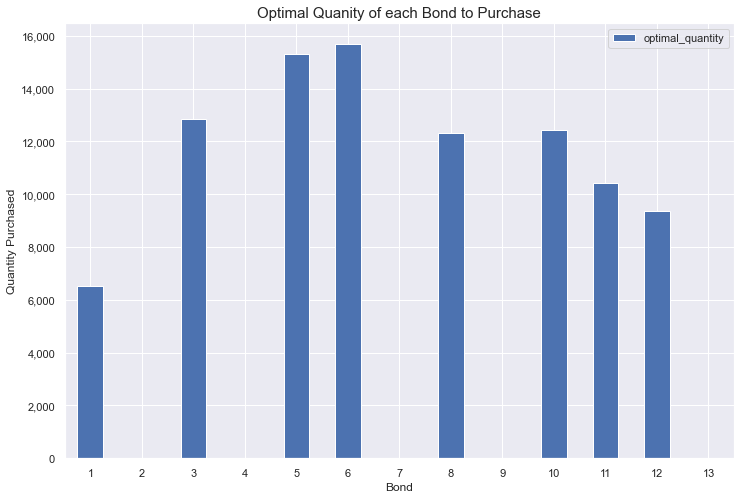

In [11]:
ax = bond_df_optimal.plot.bar(x='Bond', y='optimal_quantity', rot=0, figsize=(12,8))
plt.xlabel('Bond')
plt.ylabel('Quantity Purchased')
plt.title('Optimal Quanity of each Bond to Purchase',size=15)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

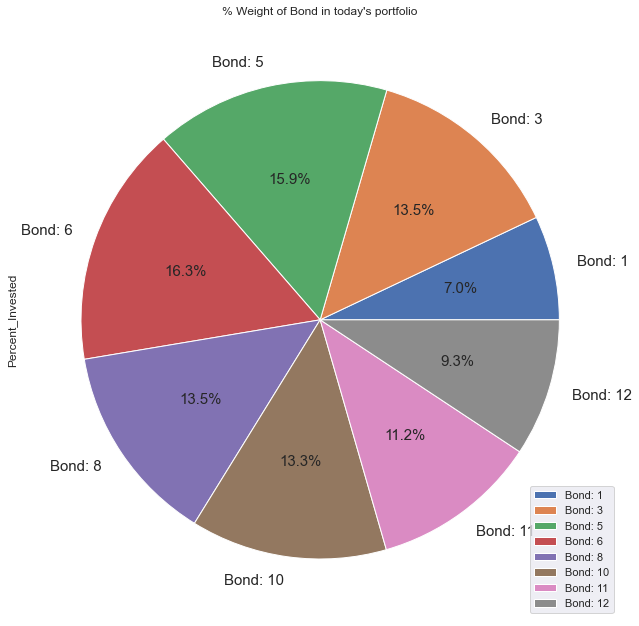

In [12]:
pie_df = bond_df_optimal[bond_df_optimal.Percent_Invested>0]
bond_labels = [f'Bond: {bond}' for bond in pie_df.Bond]
pie_df.plot.pie(y='Percent_Invested', labels=bond_labels, figsize=(11,11),autopct='%1.1f%%',textprops={'fontsize':15});
plt.title("% Weight of Bond in today's portfolio");

In [13]:
liability_df_optimal

,Year,Liability,shadow_price
0,1,1200000,-0.971429
1,2,1800000,-0.923671
2,3,2000000,-0.909876
3,4,2000000,-0.834424
4,5,1600000,-0.653628
5,6,1500000,-0.617183
6,7,1200000,-0.530350
7,8,1000000,-0.522580


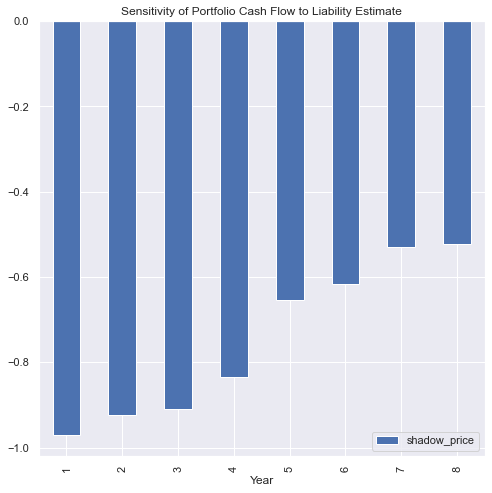

In [14]:
liability_df_optimal.plot.bar(x='Year',y='shadow_price', figsize=(8,8))
plt.title('Sensitivity of Portfolio Cash Flow to Liability Estimate');

## WSJ: Replication With Real Bond Prices

Prices were downloaded on 10/6/21

### Assumptions:
* WSJ data is in a csv file with three columns: "maturity_date", "Coupon", and "Price".
  

In [15]:
# Read data
data_wsj = pd.read_csv('wsj_data.csv')

In [16]:
# Specify date of portfolio creation and the month and day that liabilities come due
portfolio_creation_date = pd.to_datetime('2021-9-15')
liability_month = 8
liability_day = 15

There are several adjustments we need to make to the wsj data to get it into the same format as our original bond_df which will allow us to utilize the functions already created

In [17]:
# Make sure wsj maturity column is in datetime format
data_wsj_cleaned = data_wsj.copy()
data_wsj_cleaned['maturity_date'] = pd.to_datetime(data_wsj_cleaned['maturity_date'])

# Filter out bonds with maturity dates that do not end on 8/15
data_wsj_cleaned = data_wsj_cleaned[(data_wsj_cleaned['maturity_date'].dt.month == liability_month) & (data_wsj_cleaned['maturity_date'].dt.day == liability_day )]

# Create a "Maturity" column like in our old bond_df
data_wsj_cleaned['Maturity'] = data_wsj_cleaned['maturity_date'].dt.year - portfolio_creation_date.year
data_wsj_cleaned.drop(columns=['maturity_date'], inplace=True)
data_wsj_cleaned['StartTime'] = 0
data_wsj_cleaned['Bond'] = range(1,len(data_wsj_cleaned) + 1)
data_wsj_cleaned.index = range(0,len(data_wsj_cleaned)) 

In [18]:
bond_df_wsj = create_bond_df(data=data_wsj_cleaned)
bond_df_wsj.head()

,Coupon,Price,Maturity,StartTime,Bond,forward,CF_0,CF_1,CF_2,CF_3,...,CF_21,CF_22,CF_23,CF_24,CF_25,CF_26,CF_27,CF_28,CF_29,CF_30
0,1.500,101.066,1,0,1,0,-101.066,101.500,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.625,101.104,1,0,2,0,-101.104,101.625,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.250,106.032,1,0,3,0,-106.032,107.250,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.125,99.242,2,0,4,0,-99.242,0.125,100.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.500,104.050,2,0,5,0,-104.050,2.500,102.500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


With the data cleaned, we simply use the funciton previousely created to find the optimal bond amounts:

In [19]:
dollars_paid_today, bond_df_wsj_optimal, liability_df_wsj = get_optimal_results(bond_df_wsj, liability_df)

In [20]:
print(f'The cash outflow today to create the replicating portfolio is: ${dollars_paid_today:,.2f}')

The cash outflow today to create the replicating portfolio is: $-11,717,495.64


Below is the optimal quantity for each bond:

In [21]:
bond_df_wsj_optimal[['Bond','Price','Coupon','StartTime','Maturity','optimal_quantity']]

,Bond,Price,Coupon,StartTime,Maturity,optimal_quantity
0,1,101.066,1.500,0,1,0.000000
1,2,101.104,1.625,0,1,0.000000
2,3,106.032,7.250,0,1,6376.455787
3,4,99.242,0.125,0,2,0.000000
4,5,104.050,2.500,0,2,0.000000
5,6,111.036,6.250,0,2,12838.748831
6,7,99.204,0.375,0,3,0.000000
7,8,105.106,2.375,0,3,15641.170633
8,9,104.240,2.000,0,4,0.000000
9,10,123.110,6.875,0,4,16012.648436


Graphs below:

In [22]:
bond_df_wsj_optimal['MarketValue'] = bond_df_wsj_optimal['Price'] * bond_df_wsj_optimal['optimal_quantity']
bond_df_wsj_optimal['Percent_Invested'] = bond_df_wsj_optimal['MarketValue']/bond_df_wsj_optimal['MarketValue'].sum() * 100

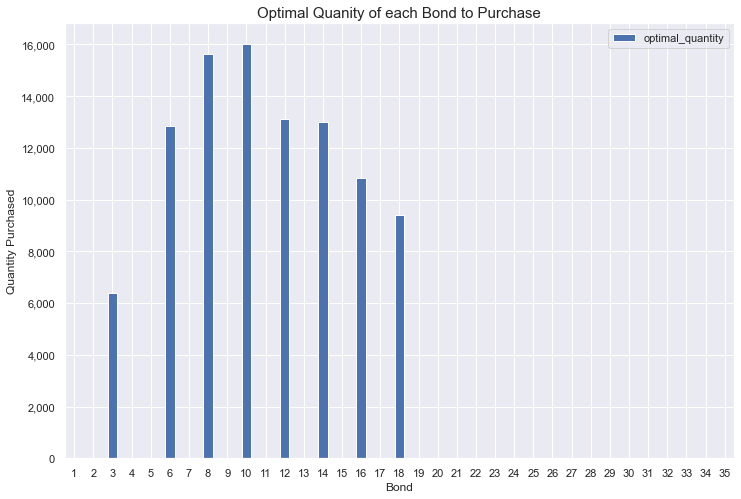

In [23]:
ax = bond_df_wsj_optimal.plot.bar(x='Bond', y='optimal_quantity', rot=0, figsize=(12,8))
plt.xlabel('Bond')
plt.ylabel('Quantity Purchased')
plt.title('Optimal Quanity of each Bond to Purchase',size=15)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

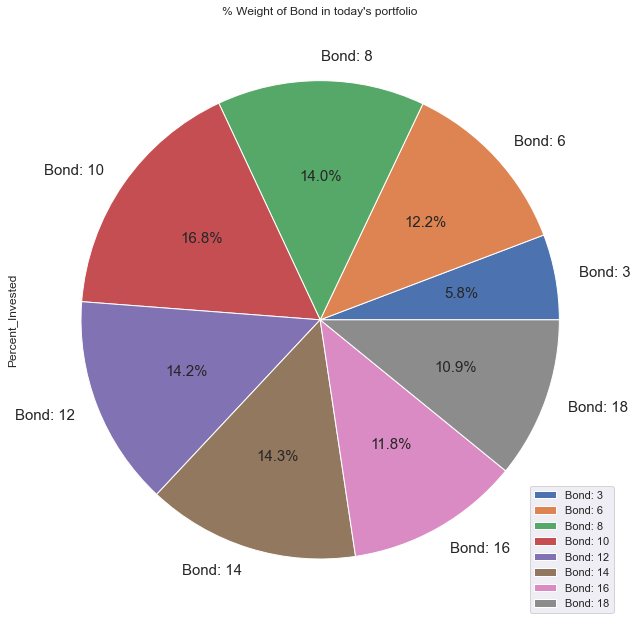

In [24]:
pie_df = bond_df_wsj_optimal[bond_df_wsj_optimal.Percent_Invested>0]
bond_labels = [f'Bond: {bond}' for bond in pie_df.Bond]
pie_df.plot.pie(y='Percent_Invested', labels=bond_labels, figsize=(11,11),autopct='%1.1f%%',textprops={'fontsize':15});
plt.title("% Weight of Bond in today's portfolio");